In [1]:
!pip install sympy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import time
# Add the src directory to the path to find the pysisso package
# This assumes your notebook is in the root directory alongside 'src'
sys.path.insert(0, str(Path.cwd() / 'src'))

from pysisso import SISSORegressor

# Plotting style setup
plt.style.use('seaborn-v0_8-whitegrid')
print("pySISSO and other libraries imported successfully.")

pySISSO and other libraries imported successfully.


In [2]:
# Load the pre-processed data
data_file = Path('benchmark_data.csv')
if not data_file.exists():
    raise FileNotFoundError(f"Could not find '{data_file.name}'. Please ensure it is in the same directory as the notebook.")

df = pd.read_csv(data_file)

# The target property
property_key = 'energy_diff'
y = df[property_key]

# The primary features are all columns except the target and identifiers
non_feature_cols = ['compound', 'A', 'B', 'min_struc_type', 'energy_diff']
feature_cols = [col for col in df.columns if col not in non_feature_cols]
X = df[feature_cols]

print(f"Data loaded successfully.")
print(f"Shape of primary feature matrix X: {X.shape}")
print(f"Shape of target vector y: {y.shape}")
print("\nFirst 5 rows of the dataset:")
display(df.head())

Data loaded successfully.
Shape of primary feature matrix X: (82, 18)
Shape of target vector y: (82,)

First 5 rows of the dataset:


,A,B,energy_diff,min_struc_type,Z(A),r_s(A),r_p(A),r_d(A),period(A),EA(A),...,E_LUMO(A),Z(B),r_s(B),r_p(B),r_d(B),period(B),EA(B),IP(B),E_HOMO(B),E_LUMO(B)
0,Ag,Br,-0.030033,RS,47,1.32,1.88,2.97,5,-1.6666,...,-0.479,35,0.75,0.88,1.87,4,-3.7393,-12.6496,-8.001,0.708
1,Cs,Br,-0.155867,RS,55,2.46,3.16,1.97,6,-0.5696,...,-0.548,35,0.75,0.88,1.87,4,-3.7393,-12.6496,-8.001,0.708
2,Cu,Br,0.152443,ZB,29,1.20,1.68,2.58,4,-1.6385,...,-0.641,35,0.75,0.88,1.87,4,-3.7393,-12.6496,-8.001,0.708
3,K,Br,-0.166176,RS,19,2.13,2.44,1.79,4,-0.6213,...,-0.697,35,0.75,0.88,1.87,4,-3.7393,-12.6496,-8.001,0.708
4,Li,Br,-0.032746,RS,3,1.65,2.00,6.93,2,-0.6981,...,-0.978,35,0.75,0.88,1.87,4,-3.7393,-12.6496,-8.001,0.708


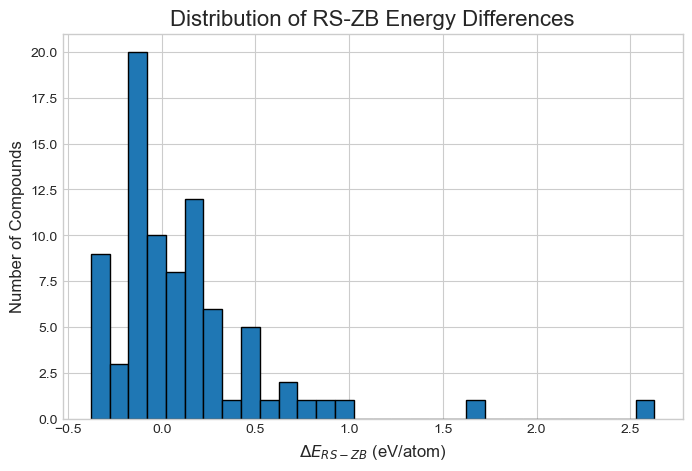

Standard deviation of target property: 0.4504 eV/atom


In [3]:
# Create a histogram of the target property (energy difference)
plt.figure(figsize=(8, 5))
plt.hist(y, bins=30, edgecolor='black')
plt.title('Distribution of RS-ZB Energy Differences', fontsize=16)
plt.xlabel('$\Delta E_{RS-ZB}$ (eV/atom)', fontsize=12)
plt.ylabel('Number of Compounds', fontsize=12)
plt.show()

print(f"Standard deviation of target property: {y.std():.4f} eV/atom")

In [5]:
# =================================================================================
#  Definitive Replication of the Original Notebook's L0 Brute-Force Search
# =================================================================================

# Define the primary features to be used, matching the notebook
selected_feature_list = ['r_s(A)', 'r_p(A)', 'r_d(A)', 'EA(A)', 'IP(A)', 
                         'r_s(B)', 'r_p(B)', 'r_d(B)', 'EA(B)', 'IP(B)']
X_primary = X[selected_feature_list]

# Define the operator sets to match the notebook's stages.
# Note: Their '|-|' is implemented in pySISSO using both 'sub' and 'abs'.
# Note: Their '^2' is 'sq'.
op_sets_pySISSO = [
    ([], []), # Stage 1: No ops
    ([{"op": "add"}, {"op": "sub"}, {"op": "abs"}], ['+', '|-|']), # Stage 2
    ([{"op": "add"}, {"op": "sub"}, {"op": "abs"}, {"op": "exp"}], ['+', '|-|', 'exp']), # Stage 3
    ([{"op": "add"}, {"op": "sub"}, {"op": "abs"}, {"op": "exp"}, {"op": "sq"}], ['+', '|-|', 'exp', '^2']) # Stage 4
]

# Store results for the final plot
feature_space_sizes = []
all_errors = []
all_times = []

# --- Main Loop to Replicate Each Stage ---
for op_rules, op_names in op_sets_pySISSO:
    print(f"\n----- STAGE: Testing Operator Set: {op_names} -----")
    
    # Configure pySISSO to exactly mimic the notebook's L0 function
    sisso_config = {
        # Depth=1 for no ops, Depth=2 to allow one level of binary ops (e.g., f1+f2)
        "depth": 1 if not op_rules else 2,
        "max_D": 3,
        "op_rules": op_rules,
        "search_strategy": "brute_force",
        # Disable the correlation pruning to match the original L0 function's behavior
        "max_feat_cross_correlation": 1.0, 
        "n_jobs": -1,
        "use_cache": True
    }

    # Initialize and run pySISSO
    sisso_l0 = SISSORegressor(**sisso_config)
    sisso_l0.fit(X_primary, y)
    
    # --- Print and Store Results for this Stage ---
    fs_size = sisso_l0.feature_space_df_.shape[1]
    feature_space_sizes.append(fs_size)
    print(f"Number of total features generated: {fs_size}")
    
    stage_errors = []
    stage_times = []
    for D in range(1, 4):
        if D in sisso_l0.models_by_dim_:
            model_data = sisso_l0.models_by_dim_[D]
            rmse = model_data['score']
            # Get the symbolic features and format them
            sym_feats = [feat.subs(sisso_l0.sym_clean_to_original_map_) for feat in model_data['sym_features']]
            best_features_str = [str(f) for f in sym_feats]

            stage_errors.append(rmse)
            stage_times.append(sisso_l0.timing_summary_.get(f'Brute-Force Search D={D}', 0))
            
            print(f"n_features: {fs_size}; {D}D  RMSE: {rmse:.3f}  best features: {best_features_str}")
        else:
            stage_errors.append(np.nan)
            stage_times.append(np.nan)
            
    all_errors.append(stage_errors)
    all_times.append(stage_times)

# Convert results to numpy arrays for plotting
all_errors = np.array(all_errors).T
all_times = np.array(all_times).T


----- STAGE: Testing Operator Set: [] -----

Starting  feature generation on CPU to depth 1...
  Using 0 operator rules. Interaction-only mode: OFF
  Depth 1: Combining 10 features from previous level...
  No new unique features generated at depth 1. Stopping.
Φ-Space generation complete. Total valid, unique features: 10

Generated feature space size: 10

--- STARTING ATTEMPT WITH SIS-SPACE SIZE = 100 ---
SIS selection size (100) >= total features (10). Using all features.

==================== Starting Brute-Force Search ====================

--- Brute-Force: Searching for Dimension 1 ---
  Evaluating 10 combinations of 1 features.
    Best model for D=1 found with score: 0.313339

--- Brute-Force: Searching for Dimension 2 ---
  Evaluating 45 combinations of 2 features.
    Best model for D=2 found with score: 0.294938

--- Brute-Force: Searching for Dimension 3 ---
  Evaluating 120 combinations of 3 features.
    Best model for D=3 found with score: 0.280145

--- Evaluating Dimensi

KeyboardInterrupt: 

In [6]:

# Define the primary features to be used, matching the notebook
selected_feature_list = ['r_s(A)', 'r_p(A)', 'r_d(A)', 'EA(A)', 'IP(A)', 
                         'r_s(B)', 'r_p(B)', 'r_d(B)', 'EA(B)', 'IP(B)']
X_primary = X[selected_feature_list]

# Define the operator sets to be tested
op_sets_pySISSO = [
    ([], []), # Stage 1: No ops
    ([{"op": "add"}, {"op": "sub"}, {"op": "abs"}], ['+', '|-|']), # Stage 2
    ([{"op": "add"}, {"op": "sub"}, {"op": "abs"}, {"op": "exp"}], ['+', '|-|', 'exp']), # Stage 3
    ([{"op": "add"}, {"op": "sub"}, {"op": "abs"}, {"op": "exp"}, {"op": "sq"}], ['+', '|-|', 'exp', '^2']) # Stage 4
]

# Store results for the final plot
feature_space_sizes = []
all_errors = []
all_times = []

# --- Main Loop to Replicate Each Stage ---
for op_rules, op_names in op_sets_pySISSO:
    print(f"\n----- STAGE: Testing Operator Set: {op_names} -----")
    
    sisso_config = {
        # Using depth=1 is the key. It creates op(f_primary) and op(f_primary, f_primary) and stops.
        "depth": 1,
        "max_D": 3,
        "op_rules": op_rules,
        "search_strategy": "brute_force",
        "max_feat_cross_correlation": 1.0, 
        "n_jobs": -1,
        "use_cache": True
    }

    # Time the execution of this stage
    t_start = time.time()
    
    sisso_l0 = SISSORegressor(**sisso_config)
    sisso_l0.fit(X_primary, y)
    
    t_end = time.time()
    
    # --- Print and Store Results ---
    fs_size = sisso_l0.feature_space_df_.shape[1]
    feature_space_sizes.append(fs_size)
    print(f"Number of total features generated: {fs_size}")
    
    stage_errors, stage_times = [], []
    for D in range(1, 4):
        if D in sisso_l0.models_by_dim_:
            model_data = sisso_l0.models_by_dim_[D]
            rmse = model_data['score']
            sym_feats = [feat.subs(sisso_l0.sym_clean_to_original_map_) for feat in model_data['sym_features']]
            best_features_str = [str(f) for f in sym_feats]

            stage_errors.append(rmse)
            stage_times.append(sisso_l0.timing_summary_.get(f'Brute-Force Search D={D}', (t_end-t_start)/3))
            
            print(f"n_features: {fs_size}; {D}D  RMSE: {rmse:.3f}  best features: {best_features_str}")
        else:
            stage_errors.append(np.nan)
            stage_times.append(np.nan)
            
    all_errors.append(stage_errors)
    all_times.append(stage_times)

# Convert results to numpy arrays for plotting
all_errors = np.array(all_errors).T
all_times = np.array(all_times).T


----- STAGE: Testing Operator Set: [] -----

Starting  feature generation on CPU to depth 1...
  Using 0 operator rules. Interaction-only mode: OFF
  Depth 1: Combining 10 features from previous level...
  No new unique features generated at depth 1. Stopping.
Φ-Space generation complete. Total valid, unique features: 10

Generated feature space size: 10

--- STARTING ATTEMPT WITH SIS-SPACE SIZE = 100 ---
SIS selection size (100) >= total features (10). Using all features.

==================== Starting Brute-Force Search ====================

--- Brute-Force: Searching for Dimension 1 ---
  Evaluating 10 combinations of 1 features.
    Best model for D=1 found with score: 0.313339

--- Brute-Force: Searching for Dimension 2 ---
  Evaluating 45 combinations of 2 features.
    Best model for D=2 found with score: 0.294938

--- Brute-Force: Searching for Dimension 3 ---
  Evaluating 120 combinations of 3 features.
    Best model for D=3 found with score: 0.280145

--- Evaluating Dimensi

In [7]:
target_col = 'energy_diff'  # RS–ZB energy difference
non_feature_cols = ['A', 'B', 'min_struc_type']
feature_cols = [c for c in df.columns if c not in [target_col] + non_feature_cols]

X = df[feature_cols].copy()
y = df[target_col].copy()

print('Number of features:', X.shape[1])

Number of features: 18


In [8]:
config = {
    'task_type': 'regression',
    'depth': 2,
    'op_rules': [ {'op': 'add'}, {'op': 'sub'}, {'op': 'mul'} ],
    'interaction_only': False,
    'max_D': 3,
    'sis_sizes': [100, 50],
    'search_strategy': 'sisso++',
    'max_feat_cross_correlation': 0.95,
    'loss': 'l2',
    'alpha': 1e-5,
    'selection_method': 'bic',
    'cv': -1,
    'fix_intercept': False,
    'n_jobs': -1,
    'random_state': 42
}

sisso = SISSORegressor(**config)

In [9]:
sisso.fit(X, y)


Starting  feature generation on CPU to depth 2...
  Using 3 operator rules. Interaction-only mode: OFF
  Depth 1: Combining 18 features from previous level...
  Depth 1: Added 622 new unique features. Total unique: 640
  Depth 2: Combining 622 features from previous level...


KeyboardInterrupt: 

In [ ]:
from pysisso import utils as sis_utils

for D, model_info in sisso.models_by_dim_.items():
    formula_str = sis_utils.print_descriptor_formula(
        model_info['sym_features'], model_info.get('coef'),
        sisso.task_type_, sisso.fix_intercept_,
        target_name='ΔE (RS–ZB)',
        clean_to_original_map=sisso.sym_clean_to_original_map_
    )
    print('\n===== Descriptor (D={}) ====='.format(D))
    print(formula_str)

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Helper: transform X once (cached)
phiX = sisso._transform_X(X)

for D, model_info in sisso.models_by_dim_.items():
    coef = model_info['coef'].flatten()
    if sisso.fix_intercept_:
        intercept = 0.0
        weights = coef
    else:
        intercept, *weights = coef
        weights = np.array(weights)
    X_D = phiX[model_info['features']]
    y_pred = intercept + X_D.values.dot(weights)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    print(f'D={D} -> RMSE={rmse:.4f} eV, R^2={r2:.3f}')

--- Constructing the proposed descriptors ---
Descriptor matrix constructed successfully.

--- Evaluating the model with YOUR provided coefficients ---
RMSE (your coefficients): 1.4610 eV/atom
R-squared (your coefficients): -9.6534

--- Performing an independent refit to find the optimal RMSE for these descriptors ---
Optimal RMSE (refit): 0.3475 eV/atom
Optimal R-squared (refit): 0.3974

Refit Model Coefficients:
  Intercept: 0.7042
  D1 (IP_diff) Coeff: 0.0469
  D2 (rpB_EAB) Coeff: 0.2268
  D3 (rdA_IPA) Coeff: -0.0095


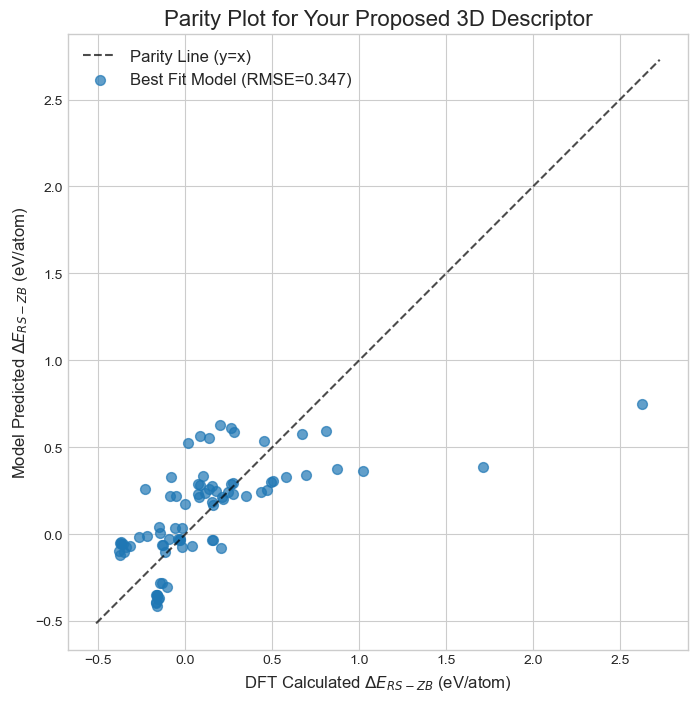

In [12]:
mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

y_true = df['energy_diff']

# --- 2. Construct Your Three Descriptors ---
print("--- Constructing the proposed descriptors ---")
# D1 = IP(B) - IP(A)
D1 = df['IP(B)'] - df['IP(A)']
# D2 = r_p(B) * EA(B)
D2 = df['r_p(B)'] * df['EA(B)']
# D3 = r_d(A) * IP(A)
D3 = df['r_d(A)'] * df['IP(A)']

# Assemble the final descriptor matrix
X_desc = pd.DataFrame({
    'D1_IP_diff': D1,
    'D2_rpB_EAB': D2,
    'D3_rdA_IPA': D3
})
print("Descriptor matrix constructed successfully.")

# --- 3. Evaluate Your Model with Your Coefficients ---
print("\n--- Evaluating the model with YOUR provided coefficients ---")
user_coeffs = np.array([-0.1874, 0.0243, -0.0134])
user_intercept = 0.0038
y_pred_user = X_desc.values @ user_coeffs + user_intercept

rmse_user = np.sqrt(mean_squared_error(y_true, y_pred_user))
r2_user = r2_score(y_true, y_pred_user)

print(f"RMSE (your coefficients): {rmse_user:.4f} eV/atom")
print(f"R-squared (your coefficients): {r2_user:.4f}")

# --- 4. Perform an Independent Refit to Find the Best Possible RMSE ---
print("\n--- Performing an independent refit to find the optimal RMSE for these descriptors ---")
model_refit = LinearRegression()
model_refit.fit(X_desc, y_true)
y_pred_refit = model_refit.predict(X_desc)

rmse_refit = np.sqrt(mean_squared_error(y_true, y_pred_refit))
r2_refit = r2_score(y_true, y_pred_refit)

print(f"Optimal RMSE (refit): {rmse_refit:.4f} eV/atom")
print(f"Optimal R-squared (refit): {r2_refit:.4f}")
print("\nRefit Model Coefficients:")
print(f"  Intercept: {model_refit.intercept_:.4f}")
print(f"  D1 (IP_diff) Coeff: {model_refit.coef_[0]:.4f}")
print(f"  D2 (rpB_EAB) Coeff: {model_refit.coef_[1]:.4f}")
print(f"  D3 (rdA_IPA) Coeff: {model_refit.coef_[2]:.4f}")

# --- 5. Visualize the Results ---
plt.figure(figsize=(8, 8))
plt.title("Parity Plot for Your Proposed 3D Descriptor", fontsize=16)
plt.xlabel("DFT Calculated $\Delta E_{RS-ZB}$ (eV/atom)", fontsize=12)
plt.ylabel("Model Predicted $\Delta E_{RS-ZB}$ (eV/atom)", fontsize=12)

# Plot the ideal y=x line
min_val = min(y_true.min(), y_pred_refit.min()) - 0.1
max_val = max(y_true.max(), y_pred_refit.max()) + 0.1
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7, label="Parity Line (y=x)")

# Plot the refit model's predictions
plt.scatter(y_true, y_pred_refit, alpha=0.7, s=50,
            label=f"Best Fit Model (RMSE={rmse_refit:.3f})")

plt.axis('equal')
plt.legend(fontsize=12)
plt.grid(True)
plt.show()